In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt

### 1. 获取掩码
- 在encoder和encoder-decoder的self-attention中，掩码和序列长度有关
- 在decoder_layer中的第一层self-attention中，掩码是下三角矩阵
- decoder输出掩码

#### 1.1 encoder和encoder-decoder的self-attention
假如一个句子的max_len是4，句子实际长度是2，mask矩阵为：
$$
\begin{pmatrix}
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$$
长度矩阵可以换成
$$
\begin{pmatrix}
1 & 1 & 0 & 0
\end{pmatrix}
$$
这样mask矩阵计算
$$
\begin{bmatrix}
1 \\
1 \\
0 \\
0
\end{bmatrix}
\times
\begin{bmatrix}
1 & 1 & 0 & 0
\end{bmatrix}
=
\mathbf{Mask}
$$

但是由于最后计算lose的时候会计算mask，所以不需要下面的两行同样作mask，例如
$$
\begin{pmatrix}
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0
\end{pmatrix}
\times
\begin{bmatrix}
v_{11} & v_{12} \\
v_{21} & v_{22} \\
v_{31} & v_{32} \\
v_{41} & v_{42} 
\end{bmatrix}
=
\begin{bmatrix}
v_{11} + v_{21} & v_{12} + v_{22} \\
v_{11} + v_{21} & v_{12} + v_{22} \\
v_{11} + v_{21} & v_{12} + v_{22} \\
v_{11} + v_{21} & v_{12} + v_{22}
\end{bmatrix}
$$
计算CrossEntropyLoss后变为
$$
\begin{bmatrix}
o_{11} & o_{12}  & o_{13} & o_{14} 
\end{bmatrix}
$$
mask之后为
$$
\begin{bmatrix}
o_{11} & o_{12} & 0 & 0 
\end{bmatrix}
$$

In [2]:
# test
# encoder/encoder-decoder
torch.manual_seed(42)
"""
输入矩阵：
    batch_size * max_seq_len * dim
    batch_size=2, max_seq_len=4, dim=8
有效长度矩阵：
    batch_size *
    batch_size=2
"""
X = torch.rand((2, 4, 8))
valid_len = torch.randint(1, 5, (2, ))
print(X, X.shape)
print(valid_len, valid_len.shape)
print()

max_len = X.shape[1]
# 获取长度矩阵
print(torch.arange(max_len)[None, :])
# 对valid_len扩容
print(valid_len.repeat_interleave(max_len)[:, None])
mask = torch.arange(max_len)[None, :] < valid_len.repeat_interleave(max_len)[:, None]
print(mask)
print()

# test
Q, K, V = X, X, X
score = torch.bmm(Q, K.permute(0, 2, 1)).reshape(-1, max_len)
print(score, score.shape)

print(score.masked_fill_(~mask, -1e6))
F.softmax(score, -1)

tensor([[[0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936, 0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274, 0.2696, 0.4414, 0.2969, 0.8317],
         [0.1053, 0.2695, 0.3588, 0.1994, 0.5472, 0.0062, 0.9516, 0.0753]],

        [[0.8860, 0.5832, 0.3376, 0.8090, 0.5779, 0.9040, 0.5547, 0.3423],
         [0.6343, 0.3644, 0.7104, 0.9464, 0.7890, 0.2814, 0.7886, 0.5895],
         [0.7539, 0.1952, 0.0050, 0.3068, 0.1165, 0.9103, 0.6440, 0.7071],
         [0.6581, 0.4913, 0.8913, 0.1447, 0.5315, 0.1587, 0.6542, 0.3278]]]) torch.Size([2, 4, 8])
tensor([3, 2]) torch.Size([2])

tensor([[0, 1, 2, 3]])
tensor([[3],
        [3],
        [3],
        [3],
        [2],
        [2],
        [2],
        [2]])
tensor([[ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True, False, False],
        [ True,  True, F

tensor([[0.5236, 0.2350, 0.2413, 0.0000],
        [0.2534, 0.5926, 0.1541, 0.0000],
        [0.4537, 0.2687, 0.2775, 0.0000],
        [0.2740, 0.5073, 0.2187, 0.0000],
        [0.5842, 0.4158, 0.0000, 0.0000],
        [0.3829, 0.6171, 0.0000, 0.0000],
        [0.5999, 0.4001, 0.0000, 0.0000],
        [0.4191, 0.5809, 0.0000, 0.0000]])

#### 1.2 decoder_layer中的第一层self-attention
例如序列长度为3, 最大长度为4，下三角矩阵:
$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 \\
1 & 1 & 1 & 1
\end{pmatrix}
$$
因为序列长度为3，实际的mask为:
$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$$
但这里其实没有必要，最后计算loss的时候会有一个loss掩码消除，后续会说明

In [3]:
# test
torch.manual_seed(46)
"""
输入矩阵：
    batch_size * max_seq_len * dim
    batch_size=2, max_seq_len=4, dim=8
有效长度矩阵：
    batch_size *
    batch_size=2
"""
X = torch.rand((2, 4, 8))
valid_len = torch.randint(1, 5, (2, ))
print(X, X.shape)
print(valid_len, valid_len.shape)
print()

batch_size = X.shape[0]
max_len = X.shape[1]
dec_valid_len = torch.arange(1, max_len + 1).repeat(batch_size)
print(dec_valid_len)
mask = torch.arange(max_len)[None, :] < dec_valid_len[:, None]
print(mask)
print()

# test
Q, K, V = X, X, X
score = torch.bmm(Q, K.permute(0, 2, 1)).reshape(-1, score.shape[-1])
# print(score, score.shape)

print(score.masked_fill_(~mask, -1e6))
F.softmax(score, -1)

tensor([[[0.6611, 0.0600, 0.5174, 0.1596, 0.7550, 0.8390, 0.0674, 0.4631],
         [0.1477, 0.3597, 0.9328, 0.0170, 0.9736, 0.4108, 0.8620, 0.8799],
         [0.6569, 0.8152, 0.4810, 0.7388, 0.0312, 0.7049, 0.7364, 0.1079],
         [0.1455, 0.2633, 0.9035, 0.6618, 0.9728, 0.9471, 0.8585, 0.9694]],

        [[0.6430, 0.4919, 0.3397, 0.7519, 0.0770, 0.1563, 0.7086, 0.5063],
         [0.2131, 0.3311, 0.7764, 0.2493, 0.1992, 0.9874, 0.2860, 0.0898],
         [0.1783, 0.0602, 0.5747, 0.9875, 0.1572, 0.1534, 0.7301, 0.7916],
         [0.6019, 0.7746, 0.4704, 0.7769, 0.8160, 0.4427, 0.1632, 0.6080]]]) torch.Size([2, 4, 8])
tensor([3, 4]) torch.Size([2])

tensor([1, 2, 3, 4, 1, 2, 3, 4])
tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True],
        [ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

ten

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.1816, 0.8184, 0.0000, 0.0000],
        [0.1588, 0.2223, 0.6189, 0.0000],
        [0.0728, 0.2366, 0.0691, 0.6214],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.3196, 0.6804, 0.0000, 0.0000],
        [0.3217, 0.1412, 0.5370, 0.0000],
        [0.1909, 0.1251, 0.1764, 0.5076]])

#### decoder输出掩码

In [4]:
# test
torch.manual_seed(46)
"""
输入矩阵：
    batch_size * max_seq_len 
    batch_size=2, max_seq_len=4, dim=8
有效长度矩阵：
    batch_size *
    batch_size=2
"""
y_hat = torch.rand((2, 4, 8))
y = torch.randint(0, 4, (2, 4))
out_valid_len = torch.randint(1, 5, (2, ))
print(y_hat, y_hat.shape)
print(y, y.shape)
print(out_valid_len, out_valid_len.shape)
print()

loss = nn.CrossEntropyLoss(reduction="none")
l = loss(y_hat.permute(0, 2, 1), y)
print(l)
print()

max_len = y_hat.shape[1]
mask = torch.arange(max_len)[None, :] < out_valid_len[:, None]
print(mask)
mask_one = torch.ones_like(y)
mask_one[~mask] = 0
l = l * mask_one
print(l, l.mean())

tensor([[[0.6611, 0.0600, 0.5174, 0.1596, 0.7550, 0.8390, 0.0674, 0.4631],
         [0.1477, 0.3597, 0.9328, 0.0170, 0.9736, 0.4108, 0.8620, 0.8799],
         [0.6569, 0.8152, 0.4810, 0.7388, 0.0312, 0.7049, 0.7364, 0.1079],
         [0.1455, 0.2633, 0.9035, 0.6618, 0.9728, 0.9471, 0.8585, 0.9694]],

        [[0.6430, 0.4919, 0.3397, 0.7519, 0.0770, 0.1563, 0.7086, 0.5063],
         [0.2131, 0.3311, 0.7764, 0.2493, 0.1992, 0.9874, 0.2860, 0.0898],
         [0.1783, 0.0602, 0.5747, 0.9875, 0.1572, 0.1534, 0.7301, 0.7916],
         [0.6019, 0.7746, 0.4704, 0.7769, 0.8160, 0.4427, 0.1632, 0.6080]]]) torch.Size([2, 4, 8])
tensor([[2, 3, 1, 0],
        [2, 3, 2, 1]]) torch.Size([2, 4])
tensor([2, 4]) torch.Size([2])

tensor([[2.0437, 2.6967, 1.8350, 2.6926],
        [2.2255, 2.2697, 2.0158, 1.9066]])

tensor([[ True,  True, False, False],
        [ True,  True,  True,  True]])
tensor([[2.0437, 2.6967, 0.0000, 0.0000],
        [2.2255, 2.2697, 2.0158, 1.9066]]) tensor(1.6447)


#### 1.4 上述掩码整合并测试

In [5]:
def sequence_mask(score_mat : torch.Tensor, valid_len : torch.Tensor) -> torch.Tensor:
    assert score_mat.dim() == 3, print(f"score_mat dim is {score_mat.dim()}")
    assert valid_len.dim() == 1, print(f"valid_len dim is {valid_len.dim()}")
    max_len = score_mat.shape[1]
    mask = torch.arange(max_len, device = valid_len.device)[None, :] < valid_len[:, None]
    return mask

device = "cuda"
# enc_mask
enc_score = torch.randn((2, 4, 8)).to(device)
enc_valid_len = torch.tensor([3, 2]).to(device)
enc_valid_len = enc_valid_len.repeat_interleave(enc_score.shape[1])

enc_mask = sequence_mask(enc_score, enc_valid_len)
print(enc_mask)

# dec_mask
dec_score = torch.randn((2, 4, 8)).to(device)
batch_size = dec_score.shape[0]
max_len = dec_score.shape[1]
dec_valid_len = torch.tensor([1, 4]).to(device)
dec_valid_len = torch.arange(1, 1 + max_len).repeat(batch_size)
dec_mask = sequence_mask(dec_score, dec_valid_len)
print(dec_mask)

# lose mask
loss = torch.randn((2, 4)).to(device)
dec_valid_len = torch.tensor([3, 2]).to(device)
loss_mask = sequence_mask(loss.unsqueeze(2), dec_valid_len)
print(loss_mask)

tensor([[ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True, False, False],
        [ True,  True, False, False],
        [ True,  True, False, False],
        [ True,  True, False, False]], device='cuda:0')
tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True],
        [ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])
tensor([[ True,  True,  True, False],
        [ True,  True, False, False]], device='cuda:0')


#### 1.5 mask_softmax

In [6]:
def mask_softmax(score : torch.Tensor, valid_len : torch.Tensor) -> torch.Tensor:
    score_mask = sequence_mask(score, valid_len)
    score = score.reshape(-1, score.shape[-1])
    score = score.masked_fill(~score_mask, -1e6)
#     print(score)
    return F.softmax(score, -1)
    
device = "cuda"
# enc_mask
enc_score = torch.randn((2, 4, 4)).to(device)
enc_valid_len = torch.tensor([3, 2]).to(device)
enc_valid_len = enc_valid_len.repeat_interleave(enc_score.shape[1])

enc_attention = mask_softmax(enc_score, enc_valid_len)
print(enc_attention)

tensor([[0.5119, 0.3282, 0.1598, 0.0000],
        [0.1228, 0.3177, 0.5594, 0.0000],
        [0.2407, 0.3907, 0.3685, 0.0000],
        [0.4797, 0.1503, 0.3700, 0.0000],
        [0.4430, 0.5570, 0.0000, 0.0000],
        [0.5710, 0.4290, 0.0000, 0.0000],
        [0.4452, 0.5548, 0.0000, 0.0000],
        [0.4024, 0.5976, 0.0000, 0.0000]], device='cuda:0')


### 2.位置编码
$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) \\
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

In [7]:
"""
    我们拿一个batch的matrix举例
    假设矩阵的batch_size=2, max_len=8，dim=4
""" 
torch.manual_seed(42)
X = torch.rand(2, 8, 4)
batch_size = X.shape[0]
max_len = X.shape[1]
dim = X.shape[2]
print(X)
pos_mat = torch.arange(max_len)
dim_mat = torch.arange(0, dim, 2) / dim
dim_mat = torch.pow(1/10000, dim_mat)
pos_embeding_mat = pos_mat[:, None] * dim_mat[None, :]
print(pos_embeding_mat, pos_embeding_mat.shape)

position_embeding = torch.zeros_like(X)
position_embeding[:, :, 0::2] = torch.sin(pos_embeding_mat)
position_embeding[:, :, 1::2] = torch.cos(pos_embeding_mat)
position_embeding

tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936],
         [0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274],
         [0.2696, 0.4414, 0.2969, 0.8317],
         [0.1053, 0.2695, 0.3588, 0.1994],
         [0.5472, 0.0062, 0.9516, 0.0753]],

        [[0.8860, 0.5832, 0.3376, 0.8090],
         [0.5779, 0.9040, 0.5547, 0.3423],
         [0.6343, 0.3644, 0.7104, 0.9464],
         [0.7890, 0.2814, 0.7886, 0.5895],
         [0.7539, 0.1952, 0.0050, 0.3068],
         [0.1165, 0.9103, 0.6440, 0.7071],
         [0.6581, 0.4913, 0.8913, 0.1447],
         [0.5315, 0.1587, 0.6542, 0.3278]]])
tensor([[0.0000, 0.0000],
        [1.0000, 0.0100],
        [2.0000, 0.0200],
        [3.0000, 0.0300],
        [4.0000, 0.0400],
        [5.0000, 0.0500],
        [6.0000, 0.0600],
        [7.0000, 0.0700]]) torch.Size([8, 2])


tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [-0.7568, -0.6536,  0.0400,  0.9992],
         [-0.9589,  0.2837,  0.0500,  0.9988],
         [-0.2794,  0.9602,  0.0600,  0.9982],
         [ 0.6570,  0.7539,  0.0699,  0.9976]],

        [[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [-0.7568, -0.6536,  0.0400,  0.9992],
         [-0.9589,  0.2837,  0.0500,  0.9988],
         [-0.2794,  0.9602,  0.0600,  0.9982],
         [ 0.6570,  0.7539,  0.0699,  0.9976]]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


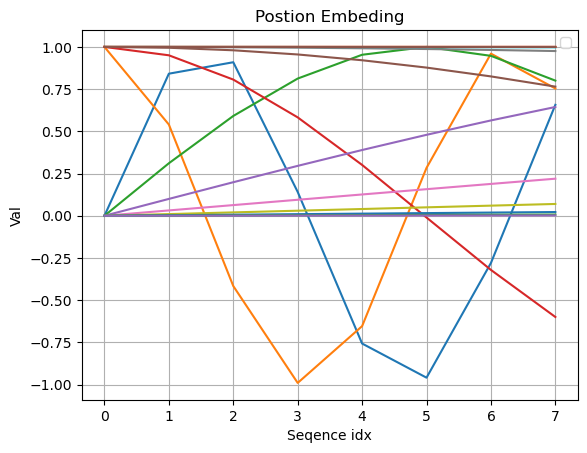

In [8]:
"""
封装成函数
"""
def postion_embeding(max_len, dim) -> torch.Tensor:
    position_embeding = torch.zeros((max_len, dim))
    
    position_mat = torch.arange(max_len)[:, None] / torch.pow(10000, 
                                                              torch.arange(0, dim, 2) / dim)[None, :]
    
    position_embeding[:, 0::2] = torch.sin(position_mat)
    position_embeding[:, 1::2] = torch.cos(position_mat)
    
    return position_embeding

def show_position(position_embeding : torch.Tensor):
    assert position_embeding.dim() == 2, print(f"enc_input dim is {position_embeding.dim()}")
    
    num_rows, num_cols = position_embeding.shape

    for col in range(num_cols):
        plt.plot(range(num_rows), position_embeding[:, col])

    plt.title("Postion Embeding") 
    plt.xlabel("Seqence idx")  
    plt.ylabel("Val")  
    plt.xticks(range(num_rows))  
    plt.legend()  
    plt.grid(True)  
    plt.show() 

enc_input = torch.rand(2, 8, 16)
position_embeding = postion_embeding(enc_input.shape[1], enc_input.shape[2])
show_position(position_embeding)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


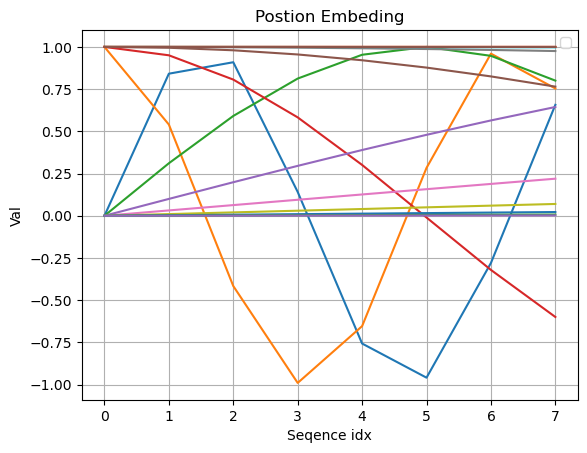

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True]], device='cuda:0')

In [9]:
"""
类函数
"""
class PositionEmbeding(nn.Module):
    def __init__(self, max_len, dims, dropout):
        super(PositionEmbeding, self).__init__()
        self.pe = postion_embeding(max_len, dims)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, X):
        assert X.shape[1:] == self.pe.shape, print(f"X shape is not equal to pe {X.shape} vs {self.pe.shape}!")
        return self.drop(X / math.sqrt(X.shape[-1]) + self.pe.to(X.device))
    
    def show_position(self):
        show_position(self.pe)

device = "cuda"
enc_input = torch.zeros(2, 8, 16)
position_embeding = PositionEmbeding(enc_input.shape[1], enc_input.shape[2], 0)
position_embeding.to(device)
position_embeding.show_position()
position_embeding(enc_input.to(device))[0] == position_embeding(enc_input.to(device))[1]

### 3. MutilHeadAttention
#### 3.1 DotProductAttention

In [10]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super(DotProductAttention, self).__init__()
        self.drop = nn.Dropout(dropout)
        
    def forward(self, querys : torch.Tensor, keys : torch.Tensor, values : torch.Tensor, valid_lens : torch.Tensor):
        assert querys.dim() == keys.dim() == values.dim() == 3
        self.attention_weights = torch.bmm(querys, keys.transpose(1, 2)) / math.sqrt(querys.shape[-1])
        # [batch_size, max_len, max_len] --> [batch_size * max_len, max_len]
        self.attention_weights = mask_softmax(self.attention_weights, valid_lens)
        self.attention_weights = self.attention_weights.reshape(querys.shape[0], querys.shape[1], querys.shape[1])
#         print(self.attention_weights)
        return torch.bmm(self.drop(self.attention_weights), values)

device = "cuda"
dpatten = DotProductAttention(0.2).to(device)
querys = torch.rand((2, 4, 8)).to(device)
keys = torch.rand((2, 4, 8)).to(device)
values = torch.rand((2, 4, 8)).to(device)

max_len = querys.shape[1]
valid_lens = torch.tensor([2, 3]).to(device)
enc_valid_lens = valid_lens.repeat_interleave(max_len)
dpatten(querys, keys, values, enc_valid_lens).shape

torch.Size([2, 4, 8])

#### 3.2 MutilHeadAttention

In [11]:
class MutilHeadAttention(nn.Module):
    def __init__(self, query_size, key_size, val_size, 
                 num_heads, num_hiddens, 
                 dropout, bias = False):
        super(MutilHeadAttention, self).__init__()
        assert num_hiddens % num_heads == 0, print(f"num_hiddens:{num_hiddens} or num_heads:{num_heads} set error!")
        
        self.num_hiddens = num_hiddens
        self.num_heads = num_heads
        self.num_hiddens_one_head = num_hiddens // num_heads
        self.W_Q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_K = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_V = nn.Linear(val_size, num_hiddens, bias=bias)
        self.W_out = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        
        self.attention = DotProductAttention(dropout)
        
    def forward(self, Q : torch.Tensor, K : torch.Tensor, V : torch.Tensor, 
                valid_lens : torch.Tensor):
        assert Q.shape[-1] == K.shape[-1] == V.shape[-1] == self.num_hiddens, print("num_hiddens is not equal to Q, K, V dims")
        assert Q.shape[0] == K.shape[0] == V.shape[0], print("batch size is not equal")
        assert valid_lens.shape[0] == Q.shape[0] * Q.shape[1] * self.num_heads, print(
            f"batch_size:{Q.shape[0]}, max_len:{Q.shape[1]}, num_heads:{self.num_heads}, lens of valid_lens:{valid_lens.shape[0]}")
        
        querys = self._transpose_qkv(self.W_Q(Q))
        keys = self._transpose_qkv(self.W_K(K))
        value = self._transpose_qkv(self.W_V(V))
        
        out = self._transpose_out(self.attention(querys, keys, value, valid_lens))
        return self.W_out(out)
        
    
    def _transpose_qkv(self, X : torch.Tensor) -> torch.Tensor:
        '''
        batch_size * max_len * num_hiddens --> batch_size * num_head * max_len * num_hiddens/num_head
        --> [ batch_size * num_head, max_len, num_hiddens/num_head ]
        '''
        shape = X.shape
        X = X.reshape(shape[0], shape[1], self.num_heads, self.num_hiddens_one_head)
        return X.permute(0, 2, 1, 3).reshape(-1, shape[1], self.num_hiddens_one_head)
    
    def _transpose_out(self, X : torch.Tensor) -> torch.Tensor:
        '''
        [ batch_size * num_head, max_len, num_hiddens/num_head ] 
    --> [ batch_size,  num_head, max_len, num_hiddens/num_head ] 
    --> [ batch_size, max_len, num_head, num_hiddens/num_head ] 
    --> [ batch_size, max_len, num_hiddens ]
        '''
        shape = X.shape
        X = X.reshape(shape[0] // self.num_heads, self.num_heads, shape[1], self.num_hiddens_one_head)
        return X.permute(0, 2, 1, 3).reshape(-1, shape[1], self.num_heads * self.num_hiddens_one_head)
    
device = "cuda"
attention = MutilHeadAttention(8, 8, 8, 2, 8, 0.2).to(device)
querys = torch.rand((2, 4, 8)).to(device)
keys = torch.rand((2, 4, 8)).to(device)
values = torch.rand((2, 4, 8)).to(device)

# encoder
max_len = querys.shape[1]
valid_lens = torch.tensor([2, 3]).to(device)
enc_valid_lens = valid_lens.repeat_interleave(max_len).repeat_interleave(2)
attention(querys, keys, values, enc_valid_lens).shape

torch.Size([2, 4, 8])

In [12]:
X = torch.arange(8).reshape(2, 4)
print(X)
Y = X.reshape(2, 2, 2)
print(Y)
Z = Y.permute(1, 0, 2)
print(Z)

tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])
tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])
tensor([[[0, 1],
         [4, 5]],

        [[2, 3],
         [6, 7]]])


### 4.FFN / ADD&Norm

In [13]:
class PositionWiseFFN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, bias = False):
        super(PositionWiseFFN, self).__init__()
        self.dense1 = nn.Linear(in_features, hidden_features, bias=bias)
        self.ac = nn.ReLU()
        self.dense2 = nn.Linear(hidden_features, out_features, bias=bias)

    def forward(self, X : torch.Tensor) -> torch.Tensor:
        return self.dense2(self.ac(self.dense1(X)))

device = "cuda"
X = torch.rand((2, 4, 8)).to(device)
ffn = PositionWiseFFN(8, 16, 8).to(device)
print(ffn(X).shape)

class AddNorm(nn.Module):
    def __init__(self, in_features, dropout, bias = False):
        super(AddNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(in_features)
        self.drop = nn.Dropout(dropout)

    def forward(self, X1 : torch.Tensor, X2 : torch.Tensor) -> torch.Tensor:
        return self.layer_norm(X1 + self.drop(X2))

an = AddNorm(2, 0.2).to(device)
an(torch.Tensor([[1, 1]]).to(device), torch.Tensor([[1, 2]]).to(device))

torch.Size([2, 4, 8])


tensor([[-1.0000,  1.0000]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)

### 5.Transformer Encoder
#### 5.1 EncoderLayer

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features,
                       dropout, index, bias = False):
        super(EncoderLayer, self).__init__()
        assert num_hiddens == in_features
        self.num_heads = num_heads
        self.index = index
        self.attention1 = MutilHeadAttention(query_size, key_size, val_size, num_heads, num_hiddens, dropout)
        self.add_norm1 = AddNorm(num_hiddens, dropout)
        self.ffn1 = PositionWiseFFN(in_features, hidden_features, out_features)
        self.add_norm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X : torch.Tensor, valid_lens : torch.Tensor) -> torch.Tensor:

        max_len = X.shape[1]
        if valid_lens is not None:
            enc_valid_lens = valid_lens.repeat_interleave(max_len).repeat_interleave(self.num_heads)

        Y1 = self.attention1(X, X, X, enc_valid_lens)
        Y2 = self.add_norm1(X, Y1)
        return self.add_norm2(Y2, self.ffn1(Y2))

device = "cuda"
X = torch.rand((2, 4, 8)).to(device)
enc_valid = torch.Tensor([2, 3]).to(device)
query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout = 0.2
enc_layer = EncoderLayer(query_size, key_size, val_size, num_heads, num_hiddens, in_features, hidden_features, out_features, dropout, 0).to(device)
out = enc_layer(X, enc_valid)
print(out.shape)
enc_layer.attention1.attention.attention_weights

torch.Size([2, 4, 8])


tensor([[[0.5173, 0.4827, 0.0000, 0.0000],
         [0.4952, 0.5048, 0.0000, 0.0000],
         [0.5054, 0.4946, 0.0000, 0.0000],
         [0.5059, 0.4941, 0.0000, 0.0000]],

        [[0.4768, 0.5232, 0.0000, 0.0000],
         [0.5180, 0.4820, 0.0000, 0.0000],
         [0.4816, 0.5184, 0.0000, 0.0000],
         [0.4754, 0.5246, 0.0000, 0.0000]],

        [[0.3282, 0.2810, 0.3908, 0.0000],
         [0.3210, 0.2792, 0.3998, 0.0000],
         [0.3402, 0.3122, 0.3476, 0.0000],
         [0.3223, 0.2688, 0.4089, 0.0000]],

        [[0.3277, 0.3802, 0.2921, 0.0000],
         [0.3133, 0.3664, 0.3203, 0.0000],
         [0.3202, 0.3618, 0.3179, 0.0000],
         [0.3179, 0.3946, 0.2874, 0.0000]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

#### 5.2 Transformer Encoder

In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, max_len, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features, num_encoder_layers,
                       dropout, bias = False):
        super(TransformerEncoder, self).__init__()
        assert num_encoder_layers > 0
        self.embeding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_embeding = PositionEmbeding(max_len, num_hiddens, dropout)
        self.layers = nn.Sequential()
        self.num_hiddens = num_hiddens
        for i in range(num_encoder_layers):
            self.layers.add_module(f"encoder_layer_{i}", 
                      EncoderLayer(query_size, key_size, val_size, num_heads, num_hiddens, 
                                   in_features, hidden_features, out_features, dropout, i))
    def forward(self, X : torch.Tensor, valid_lens : torch.Tensor) -> (torch.Tensor, torch.Tensor):
        assert X.dim() == 2
        X_emb = self.embeding(X)
        # print(X_emb.shape)
        X_emb = self.pos_embeding(X_emb)
        for layer in self.layers:
            X_emb = layer(X_emb, valid_lens)

        return X_emb, valid_lens

device = "cuda"
X = torch.randint(0, 16, (2, 4)).to(device)
enc_valid = torch.Tensor([2, 3]).to(device)
vocab_size = 16
query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout, num_encoder_layers = 0.2, 2
encoder = TransformerEncoder(vocab_size, X.shape[1], query_size, key_size, val_size, num_heads, num_hiddens, 
                         in_features, hidden_features, out_features, num_encoder_layers, dropout).to(device)
out = encoder(X, enc_valid)
print(out[0].shape)
print(out[1])
print(encoder.layers[0].attention1.attention.attention_weights)
# enc_layer.attention1.attention.attention_weights

torch.Size([2, 4, 8])
tensor([2., 3.], device='cuda:0')
tensor([[[0.4984, 0.5016, 0.0000, 0.0000],
         [0.5322, 0.4678, 0.0000, 0.0000],
         [0.4960, 0.5040, 0.0000, 0.0000],
         [0.4828, 0.5172, 0.0000, 0.0000]],

        [[0.5320, 0.4680, 0.0000, 0.0000],
         [0.5306, 0.4694, 0.0000, 0.0000],
         [0.5080, 0.4920, 0.0000, 0.0000],
         [0.5064, 0.4936, 0.0000, 0.0000]],

        [[0.2717, 0.3446, 0.3837, 0.0000],
         [0.2766, 0.3341, 0.3893, 0.0000],
         [0.2926, 0.3274, 0.3801, 0.0000],
         [0.3357, 0.3146, 0.3496, 0.0000]],

        [[0.3258, 0.3346, 0.3396, 0.0000],
         [0.3341, 0.3323, 0.3336, 0.0000],
         [0.3588, 0.3288, 0.3124, 0.0000],
         [0.3792, 0.3230, 0.2978, 0.0000]]], device='cuda:0',
       grad_fn=<ViewBackward0>)


### 6.Transformer Decoder
#### 6.1 DecoderLayer

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features,
                       dropout, index, bias = False):
        super(DecoderLayer, self).__init__()
        assert num_hiddens == in_features
        self.index = index
        self.num_heads = num_heads
        self.self_attention = MutilHeadAttention(query_size, key_size, val_size, num_heads, num_hiddens, dropout)
        self.add_norm1 = AddNorm(num_hiddens, dropout)
        
        self.encoder_decoder_attention = MutilHeadAttention(query_size, key_size, val_size, num_heads, num_hiddens, dropout)
        self.add_norm2 = AddNorm(num_hiddens, dropout)
        
        self.ffn = PositionWiseFFN(in_features, hidden_features, out_features)
        self.add_norm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X : torch.Tensor, encoder_states : (torch.Tensor, torch.Tensor)) -> torch.Tensor:
        batch_size = X.shape[0]
        max_len = X.shape[1]
        encoder_output, encoder_valid_lens = encoder_states[0], encoder_states[1]
        # print(X.shape, encoder_output.shape, encoder_valid_lens.shape)
        if valid_lens is not None:
            dec_valid_lens = torch.arange(1, 1 + max_len).repeat(batch_size).repeat(self.num_heads).to(X.device)
            # print(dec_valid_lens.shape[0])
        Y1 = self.add_norm1(X, self.self_attention(X, X, X, dec_valid_lens))

        enc_valid_lens = encoder_valid_lens.repeat_interleave(max_len).repeat_interleave(self.num_heads)
        Y2 = self.add_norm2(Y1, self.encoder_decoder_attention(Y1, encoder_output, encoder_output, enc_valid_lens))
        
        return self.add_norm3(Y2, self.ffn(Y2))

device = "cuda"
dec_input = torch.rand((2, 4, 8)).to(device)
enc_output = torch.rand((2, 4, 8)).to(device)
enc_valid_lens = torch.tensor([2, 3]).to(device)

query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout = 0.2
decoderlayer = DecoderLayer(query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features,
                       dropout, 0).to(device)
print(decoderlayer(dec_input, (enc_output, enc_valid_lens)).shape)
print(decoderlayer.self_attention.attention.attention_weights)
print(decoderlayer.encoder_decoder_attention.attention.attention_weights)

torch.Size([2, 4, 8])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5207, 0.4793, 0.0000, 0.0000],
         [0.3421, 0.3215, 0.3363, 0.0000],
         [0.2565, 0.2409, 0.2455, 0.2572]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4866, 0.5134, 0.0000, 0.0000],
         [0.3191, 0.3310, 0.3500, 0.0000],
         [0.2302, 0.2471, 0.2624, 0.2603]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4595, 0.5405, 0.0000, 0.0000],
         [0.3337, 0.3239, 0.3425, 0.0000],
         [0.2382, 0.2519, 0.2491, 0.2608]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5018, 0.4982, 0.0000, 0.0000],
         [0.3320, 0.3323, 0.3357, 0.0000],
         [0.2521, 0.2502, 0.2494, 0.2483]]], device='cuda:0',
       grad_fn=<ViewBackward0>)
tensor([[[0.5097, 0.4903, 0.0000, 0.0000],
         [0.4950, 0.5050, 0.0000, 0.0000],
         [0.4982, 0.5018, 0.0000, 0.0000],
         [0.4886, 0.5114, 0.0000, 0.0000]],

        [[0.4796, 0.5204, 0.0000, 0.0000],
         [0.4564

#### 6.2 Transformer Decoder

In [17]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, max_len, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features, num_decoder_layers,
                       dropout, bias = False):
        super(TransformerDecoder, self).__init__()
        assert num_decoder_layers > 0
        self.embeding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_embeding = PositionEmbeding(max_len, num_hiddens, dropout)
        self.layers = nn.Sequential()
        self.num_hiddens = num_hiddens
        for i in range(num_decoder_layers):
            self.layers.add_module(f"decoder_layer_{i}", 
                      DecoderLayer(query_size, key_size, val_size, num_heads, num_hiddens, 
                                   in_features, hidden_features, out_features, dropout, i))

        self.dense = nn.Linear(num_hiddens, vocab_size)
            
    def init_states(self, encoder_states):
        self.encoder_states = encoder_states
        
    def forward(self, X : torch.Tensor) -> torch.Tensor:
        assert X.dim() == 2
        X = self.embeding(X)
        # print(X_emb.shape)
        X = self.pos_embeding(X)
        for layer in self.layers:
            X = layer(X, self.encoder_states)

        return self.dense(X)

device = "cuda"
dec_input = torch.randint(0, 16, (2, 4)).to(device)
enc_out = torch.rand((2, 4, 8)).to(device)
enc_valid = torch.Tensor([3, 1]).to(device)
vocab_size = 16
query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout, num_encoder_layers = 0.2, 2
decoder = TransformerDecoder(vocab_size, dec_input.shape[1], query_size, key_size, val_size, num_heads, num_hiddens, 
                         in_features, hidden_features, out_features, num_encoder_layers, dropout).to(device)
decoder.init_states((enc_out, enc_valid))
out = decoder(X)
print(out.shape)
print(decoder.layers[0].self_attention.attention.attention_weights)
print(decoder.layers[0].encoder_decoder_attention.attention.attention_weights)

torch.Size([2, 4, 16])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4652, 0.5348, 0.0000, 0.0000],
         [0.3232, 0.3437, 0.3331, 0.0000],
         [0.2302, 0.2825, 0.2435, 0.2438]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5417, 0.4583, 0.0000, 0.0000],
         [0.3277, 0.3468, 0.3255, 0.0000],
         [0.2613, 0.2384, 0.2418, 0.2586]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5244, 0.4756, 0.0000, 0.0000],
         [0.3186, 0.3471, 0.3343, 0.0000],
         [0.2481, 0.2548, 0.2539, 0.2431]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5221, 0.4779, 0.0000, 0.0000],
         [0.3783, 0.3218, 0.2999, 0.0000],
         [0.2684, 0.2323, 0.2152, 0.2842]]], device='cuda:0',
       grad_fn=<ViewBackward0>)
tensor([[[0.3374, 0.3635, 0.2991, 0.0000],
         [0.3288, 0.3609, 0.3103, 0.0000],
         [0.3557, 0.3730, 0.2712, 0.0000],
         [0.3597, 0.3754, 0.2649, 0.0000]],

        [[0.3329, 0.3332, 0.3339, 0.0000],
         [0.342

### 7.Transformer

In [18]:
class Transformer(nn.Module):
    def __init__(self, enc_vocab_size, dec_vocab_size, max_len, query_size, key_size, val_size, num_heads, num_hiddens, 
                       in_features, hidden_features, out_features, num_decoder_layers,
                       dropout, bias = False):
        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(enc_vocab_size, max_len, query_size, key_size, val_size, num_heads, num_hiddens, 
                         in_features, hidden_features, out_features, num_encoder_layers, dropout)
        self.decoder = TransformerDecoder(dec_vocab_size, max_len, query_size, key_size, val_size, num_heads, num_hiddens, 
                         in_features, hidden_features, out_features, num_encoder_layers, dropout)

    def forward(self, X, Y, enc_valid_lens):
        enc_output, enc_valid_lens = self.encoder(X, enc_valid_lens)
        self.decoder.init_states((enc_output, enc_valid_lens))
        return self.decoder(Y)

device = "cuda"
vocab_size = 16
query_size, key_size, val_size, num_heads, num_hiddens = 8, 8, 8, 2, 8
in_features, hidden_features, out_features = 8, 16, 8
dropout, num_encoder_layers = 0.2, 2
model = Transformer(vocab_size, vocab_size, X.shape[1], query_size, key_size, val_size, num_heads, num_hiddens, 
                    in_features, hidden_features, out_features, num_encoder_layers, dropout).to(device)
X = torch.randint(0, 16, (2, 4)).to(device)
enc_valid_lens = torch.Tensor([2, 3]).to(device)
Y = torch.randint(0, 16, (2, 4)).to(device)

y_hat = model(X, Y, enc_valid_lens)
print(y_hat.shape)
print(model.encoder.layers[0].attention1.attention.attention_weights)
print(model.decoder.layers[0].self_attention.attention.attention_weights)
print(model.decoder.layers[0].encoder_decoder_attention.attention.attention_weights)

torch.Size([2, 4, 16])
tensor([[[0.5083, 0.4917, 0.0000, 0.0000],
         [0.4994, 0.5006, 0.0000, 0.0000],
         [0.5022, 0.4978, 0.0000, 0.0000],
         [0.4913, 0.5087, 0.0000, 0.0000]],

        [[0.4998, 0.5002, 0.0000, 0.0000],
         [0.5078, 0.4922, 0.0000, 0.0000],
         [0.5195, 0.4805, 0.0000, 0.0000],
         [0.4999, 0.5001, 0.0000, 0.0000]],

        [[0.2611, 0.2654, 0.4734, 0.0000],
         [0.2522, 0.2654, 0.4824, 0.0000],
         [0.3054, 0.2968, 0.3977, 0.0000],
         [0.3127, 0.3177, 0.3695, 0.0000]],

        [[0.3175, 0.3048, 0.3777, 0.0000],
         [0.3455, 0.3189, 0.3356, 0.0000],
         [0.3390, 0.3826, 0.2784, 0.0000],
         [0.3535, 0.3931, 0.2534, 0.0000]]], device='cuda:0',
       grad_fn=<ViewBackward0>)
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4788, 0.5212, 0.0000, 0.0000],
         [0.3017, 0.2888, 0.4096, 0.0000],
         [0.1866, 0.1986, 0.3311, 0.2837]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.517

### 8. MaskCrossEntropy

In [19]:
class MaskCrossEntropy(nn.CrossEntropyLoss):
    def __init__(self):
        super(MaskCrossEntropy, self).__init__(reduction="none")
    def forward(self, y_hat : torch.Tensor, y : torch.Tensor, valid_lens : torch.Tensor):
        loss_mat = super().forward(y_hat.transpose(2, 1), y)
        mask = sequence_mask(loss_mat.unsqueeze(2), valid_lens)
        # print(mask)
        loss = loss_mat.masked_fill(~mask, 0)
        # print(loss)
        return loss.mean()
# lose mask
device = "cuda"
y_hat = torch.randn((2, 4, 8)).to(device)
y = torch.randint(0, 4, (2, 4)).to(device)
dec_valid_len = torch.tensor([3, 2]).to(device)
loss = MaskCrossEntropy()
loss(y_hat, y, dec_valid_len)

tensor(1.7332, device='cuda:0')

### 9.训练

In [20]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [28]:
X, X_valid_len, Y, Y_valid_len = next(iter(train_iter))
print(X.shape, X_valid_len.shape, Y.shape, Y_valid_len.shape)

model = Transformer(len(src_vocab), len(tgt_vocab), num_steps, 
                    key_size, query_size, value_size, num_heads, num_hiddens, 
                    ffn_num_input, ffn_num_hiddens, num_hiddens, 
                    num_layers, dropout)

# Y_hat = model(X, Y, X_valid_len)
# loss(Y_hat, Y, Y_valid_len)

model = model.to(device)
def xavier_init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
model.apply(xavier_init_weights)
model.train()
loss = MaskCrossEntropy()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# animator = d2l.Animator(xlabel='epoch', ylabel='loss',
#                             xlim=[10, num_epochs])
for epoch in range(num_epochs):
    for X, X_valid_len, Y, Y_valid_len in train_iter:
        optimizer.zero_grad()
        
        X = X.to(device)
        X_valid_len = X_valid_len.to(device)
        Y = Y.to(device)
        Y_valid_len = Y_valid_len.to(device)

        bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
        decoder_input = d2l.concat([bos, Y[:, :-1]], 1)
        Y_hat = model(X, decoder_input, X_valid_len)
        l = loss(Y_hat, Y, Y_valid_len)
        l.backward()
        d2l.grad_clipping(model, 1)
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'epoch:{epoch}, loss {l}')
        

torch.Size([64, 10]) torch.Size([64]) torch.Size([64, 10]) torch.Size([64])
epoch:9, loss 0.9308127760887146
epoch:19, loss 0.8470646142959595
epoch:29, loss 0.8670310378074646
epoch:39, loss 0.5179930329322815
epoch:49, loss 0.5300111174583435
epoch:59, loss 0.4262419641017914
epoch:69, loss 0.35343873500823975
epoch:79, loss 0.37463483214378357
epoch:89, loss 0.44767308235168457
epoch:99, loss 0.31282687187194824
epoch:109, loss 0.2868809700012207
epoch:119, loss 0.3600732684135437
epoch:129, loss 0.2135140746831894
epoch:139, loss 0.29954126477241516
epoch:149, loss 0.23430106043815613
epoch:159, loss 0.30735236406326294
epoch:169, loss 0.24963843822479248
epoch:179, loss 0.23414047062397003
epoch:189, loss 0.18430586159229279
epoch:199, loss 0.26400232315063477


loss 0.001, 19076.1 tokens/sec on cuda:0


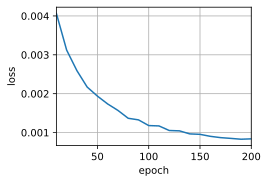

In [37]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence.

    Defined in :numref:`sec_utils`"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskCrossEntropy()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

net = Transformer(len(src_vocab), len(tgt_vocab), num_steps, 
                    key_size, query_size, value_size, num_heads, num_hiddens, 
                    ffn_num_input, ffn_num_hiddens, num_hiddens, 
                    num_layers, dropout)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [36]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence.

    Defined in :numref:`sec_utils`"""
    # Set `net` to eval mode for inference
    net.eval()
    net.to(device)
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_states((enc_outputs, enc_valid_len))
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y = net.decoder(dec_X)
        # We use the token with the highest prediction likelihood as input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
        translation, dec_attention_weight_seq = predict_seq2seq(
                net, eng, src_vocab, tgt_vocab, num_steps, device, False)
        print(f'{eng} => {translation}, label:{fra}',
              f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

X shape is not equal to pe torch.Size([1, 1, 32]) vs torch.Size([10, 32])!


AssertionError: None